In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from scipy.io import mmread

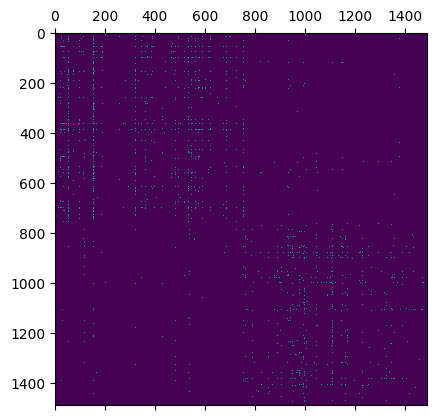

In [3]:
# Load graph dataset
polblogs_path = "../data/polblogs.mtx"

# Format is mtx, so we need to read it in a special way

# Load the graph
polblogs = mmread(polblogs_path)
plt.matshow(polblogs.todense())

In [4]:
import networkx as nx

# Use networkx to get the shortest path lengths
G = nx.from_scipy_sparse_array(polblogs)
dists = nx.floyd_warshall_numpy(G)

KeyboardInterrupt: 

In [ ]:
# from hyperdt.product_embed.product import ProductSpace
# from hyperdt.product_embed.embedding import embed

# ps = ProductSpace(dims=[2, 2, 2], curvatures=[-1, 0, 1])
# embeds = embed(dists[:20, :20], ps, print_freq=1)

In [ ]:
# x_embed = torch.cat([component.embed_point(0.1 * torch.rand(20, component.dim)) for component in ps.components], axis=1)
# x_embed = torch.nan_to_num(x_embed, 0)

# d = [c.dist(x_i, y_i) for c, x_i, y_i in zip(ps.components, ps.split(x_embed), ps.split(x_embed))]
# [d_c.shape for d_c in d]

In [ ]:
# !pip install geoopt

In [ ]:
import geoopt
from tqdm.notebook import tqdm

In [ ]:
# pm = ProductSpace(dims=[2, 2, 2], curvatures=[-1, 0, 1])
hyp = geoopt.Lorentz()
euc = geoopt.Euclidean()
sph = geoopt.Sphere()
pm = geoopt.ProductManifold((hyp, 3), (euc, 2), (sph, 3))

# Here's how you access individual manifolds:
for manifold in pm.manifolds:
    print(manifold, manifold.ndim)

Lorentz manifold 1
Euclidean(ndim=0) manifold 0
Sphere manifold 1


In [ ]:
# Params
N_POINTS = len(G)
BURN_IN_LR = 0.00001
BURN_IN_ITERS = 1000
LR = 0.01
ITERS = 3000
LOSS_WINDOW = 100
SUBSAMPLE = 32

# Randomly initialize embeddings
x_embed = torch.zeros(N_POINTS, 3 + 2 + 3)
x_embed[:, 0:3] = hyp.expmap0(
    torch.cat([torch.zeros(N_POINTS, 1), torch.randn(N_POINTS, 2)], dim=1)
)  # Random for hyperbolic (expmap0 is the exponential map at the origin)
x_embed[:, 3:5] = torch.randn(N_POINTS, 2)  # Random for Euclidean
x_embed[:, 5:8] = sph.expmap(
    x=torch.cat([torch.ones(N_POINTS, 1), torch.zeros(N_POINTS, 2)], dim=1),
    u=torch.cat([torch.zeros(N_POINTS, 1), torch.randn(N_POINTS, 2)], dim=1),
)  # Map to sphere
x_embed = geoopt.ManifoldParameter(x_embed, manifold=pm)

# Optimizer
opt = geoopt.optim.RiemannianAdam(params=[x_embed], lr=0.01)


# Pairwise dists function
def pdist(x_embed):
    n = x_embed.shape[0]
    dists = torch.zeros((n, n), device=x_embed.device)
    for i in range(n):
        for j in range(i + 1, n):
            dists[i, j] = pm.dist(x_embed[i], x_embed[j])
    return dists


# Loss function
def loss(x_embed, dists, ignore_inf=True, random_subsample=None):
    if random_subsample:
        idx = torch.randperm(dists.shape[0])[:random_subsample]
        dists = dists[idx][:, idx]
        x_embed = x_embed[idx]

    n = dists.shape[0]
    idx = torch.triu_indices(n, n, offset=1)

    pdist_true = dists[idx[0], idx[1]]
    pdist_est = pdist(x_embed)[idx[0], idx[1]]

    if ignore_inf:
        non_inf = ~torch.isinf(pdist_true)
        pdist_true = pdist_true[non_inf]
        pdist_est = pdist_est[non_inf]

    # return torch.nn.functional.mse_loss(pdist_est, pdist_true)
    return torch.abs(pdist_est / pdist_true - 1).mean()


# Get everything ready for torch
dists_torch = torch.tensor(dists[:N_POINTS, :N_POINTS], dtype=torch.float32)
my_tqdm = tqdm(total=BURN_IN_ITERS + ITERS)

# # First dists - verify it's not nan
# if torch.isnan(dists_torch).any():
#     print("dists_torch contains NaNs")
# elif torch.isnan(x_embed).any():
#     print("x_embed contains NaNs")
# elif torch.isnan(pdist(x_embed)).any():
#     print("pdists(x_embed) contains NaNs")
# elif torch.isnan(loss(x_embed, dists_torch, pm)).any():
#     print("loss(x_embed, dists_torch, pm) contains NaNs")

# # Check for infs as well
# elif torch.isinf(dists_torch).any():
#     print("dists_torch contains infs")
# elif torch.isinf(x_embed).any():
#     print("x_embed contains infs")
# elif torch.isinf(pdist(x_embed)).any():
#     print("pdists(x_embed) contains infs")
# elif torch.isinf(loss(x_embed, dists_torch, pm)).any():
#     print("loss(x_embed, dists_torch, pm) contains infs")

# Train loop
# else:
losses = []
for lr, n_iters in ((0.00001, BURN_IN_ITERS), (0.1, ITERS)):
    for i in range(n_iters):
        opt.zero_grad()
        l = loss(x_embed, dists_torch, pm, random_subsample=SUBSAMPLE)
        l.backward()
        losses.append(l.item())
        opt.step()

        # TQDM management
        my_tqdm.update(1)
        my_tqdm.set_description(f"Loss: {l.item():.4f}, Average Loss: {np.mean(losses[-LOSS_WINDOW:]):.4f}")

  0%|          | 0/4000 [00:00<?, ?it/s]

In [ ]:
# Save the embeddings
x_embed.detach().numpy().dump(f"polblogs_embeddings_sub{SUBSAMPLE}.npy")

In [ ]:
# Sanity checks: do the norms work out?

torch.allclose((x_embed[:, 1:3] ** 2).sum(axis=1) - x_embed[:, 0] ** 2, torch.Tensor([-1]), atol=1e-4)
assert torch.allclose(x_embed[:, 5:8].norm(dim=1), torch.Tensor([1.0]), atol=1e-4)

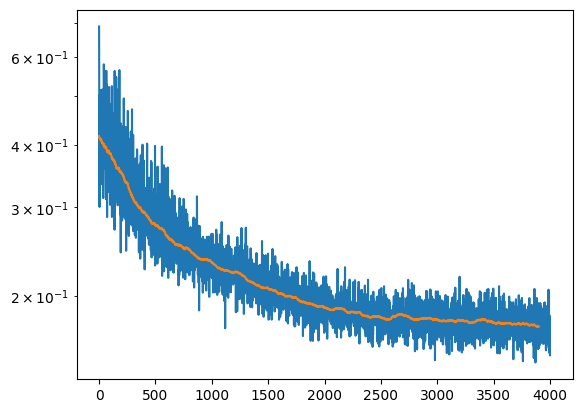

In [ ]:
# Plot the losses
plt.plot(losses)
plt.plot(np.convolve(losses, np.ones(LOSS_WINDOW) / LOSS_WINDOW, mode="valid"))
plt.yscale("log")
plt.show()

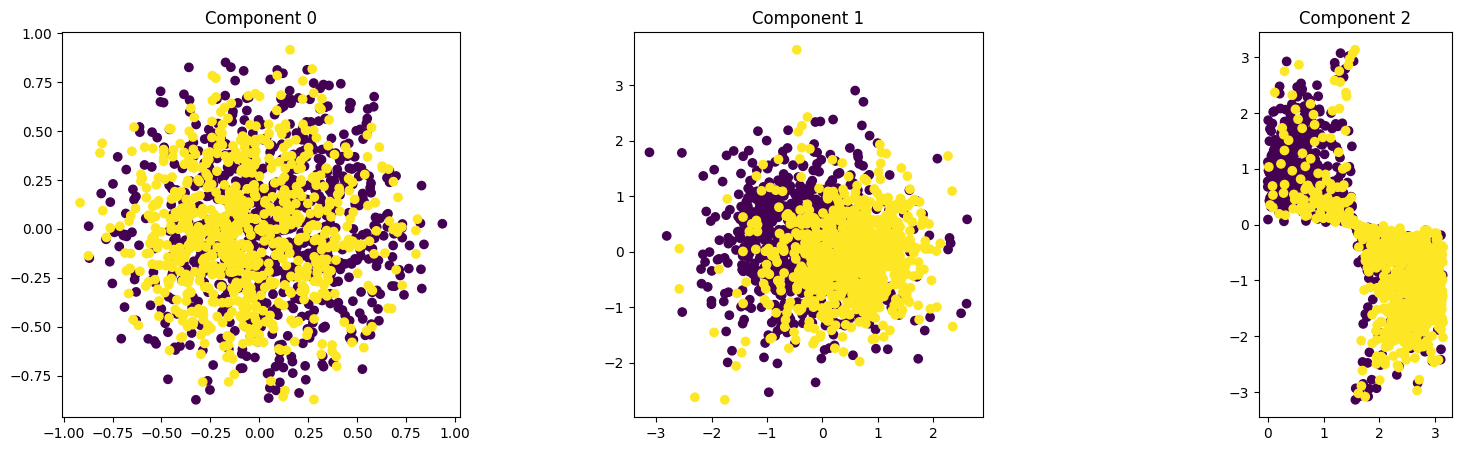

In [ ]:
import pandas as pd

polblogs_labels = pd.read_table("../data/polblogs_labels.tsv", header=None)[0][:N_POINTS]


def hyperboloid_to_poincare(X):
    # Spatial components: all columns except the first
    x_space = X[:, 1:]

    # Time-like component: first column, reshaped for broadcasting
    x_time = X[:, 0:1]

    # Convert to Poincaré ball coordinates
    poincare_coords = x_space / (1 + x_time)

    return poincare_coords


def spherical_to_polar(X):
    # Radius computation
    r = torch.norm(X, dim=1, keepdim=True)

    # Prepare output tensor
    out = torch.zeros_like(X)
    out[:, 0] = r.squeeze()  # Set the radius

    # Compute angles
    for i in range(1, X.size(1)):
        if i == X.size(1) - 1:
            # Last angle, use atan2 for full 360 degree
            out[:, i] = torch.atan2(X[:, i - 1], X[:, i - 2])
        else:
            # Compute angle from the higher dimension 'hypotenuse'
            hypotenuse = torch.norm(X[:, i:], dim=1, keepdim=True)
            # Prevent division by zero
            safe_hypotenuse = torch.where(hypotenuse > 0, hypotenuse, torch.tensor(1.0).to(X.device))
            # Ensure acos receives values within [-1, 1] and preserve dimensions
            angle = torch.acos(torch.clamp(X[:, i : i + 1] / safe_hypotenuse, -1, 1))
            out[:, i] = angle.squeeze()

    return out[:, 1:]


# Plot each component of the embeddings
fig, axs = plt.subplots(1, 3, figsize=(20, 5))
for i, ax in enumerate(axs):
    if i == 0:  # hyperboloid --> poincare
        x = hyperboloid_to_poincare(x_embed[:, 0:3])
    elif i == 1:
        x = x_embed[:, 3:5]
    elif i == 2:  # spherical --> polar
        x = spherical_to_polar(x_embed[:, 5:8])
    x = x.detach().numpy()
    ax.scatter(x[:, 0], x[:, 1], c=polblogs_labels)
    ax.set_title(f"Component {i}")
    ax.set_aspect("equal")